In [1]:
import pandas as pd
import sqlite3

In [2]:
connect = sqlite3.connect('../data/checking-logs.sqlite')

Подготовим таблицу. Выберем из datetime отдельно дату и время

In [3]:
query = '''
SELECT uid, timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''
commits = pd.io.sql.read_sql(query, connect, parse_dates=['timestamp'])
commits['date'] = commits.timestamp.dt.date
commits['hour'] = commits.timestamp.dt.hour
commits

,uid,timestamp,date,hour
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5
...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,2020-05-21,20
3203,user_1,2020-05-21 20:22:41.785725,2020-05-21,20
3204,user_1,2020-05-21 20:22:41.877806,2020-05-21,20
3205,user_1,2020-05-21 20:37:00.129678,2020-05-21,20


Добавим колонку с названием времени суток

In [4]:
commits['daytime'] = pd.cut(commits.hour,
                            bins=[0, 4, 10, 17, 24],
                            labels=['nigth', 'morning', 'afternoon', 'evening'],
                            right=False,
                            include_lowest=True)
commits

,uid,timestamp,date,hour,daytime
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5,morning
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5,morning
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5,morning
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5,morning
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5,morning
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,2020-05-21,20,evening
3203,user_1,2020-05-21 20:22:41.785725,2020-05-21,20,evening
3204,user_1,2020-05-21 20:22:41.877806,2020-05-21,20,evening
3205,user_1,2020-05-21 20:37:00.129678,2020-05-21,20,evening


Отсортируем по дате

In [5]:
commits_group = commits.groupby('daytime').date.value_counts().unstack(0)
commits_group

daytime,nigth,morning,afternoon,evening
date,,,,
2020-04-17,NaN,13.0,10.0,NaN
2020-04-18,NaN,1.0,33.0,35.0
2020-04-19,2.0,4.0,16.0,11.0
2020-04-20,NaN,NaN,12.0,13.0
2020-04-21,NaN,NaN,NaN,25.0
2020-04-22,NaN,NaN,4.0,24.0
2020-04-23,2.0,6.0,15.0,20.0
2020-04-24,NaN,NaN,4.0,12.0
2020-04-25,1.0,21.0,33.0,49.0


Построим гистограмму

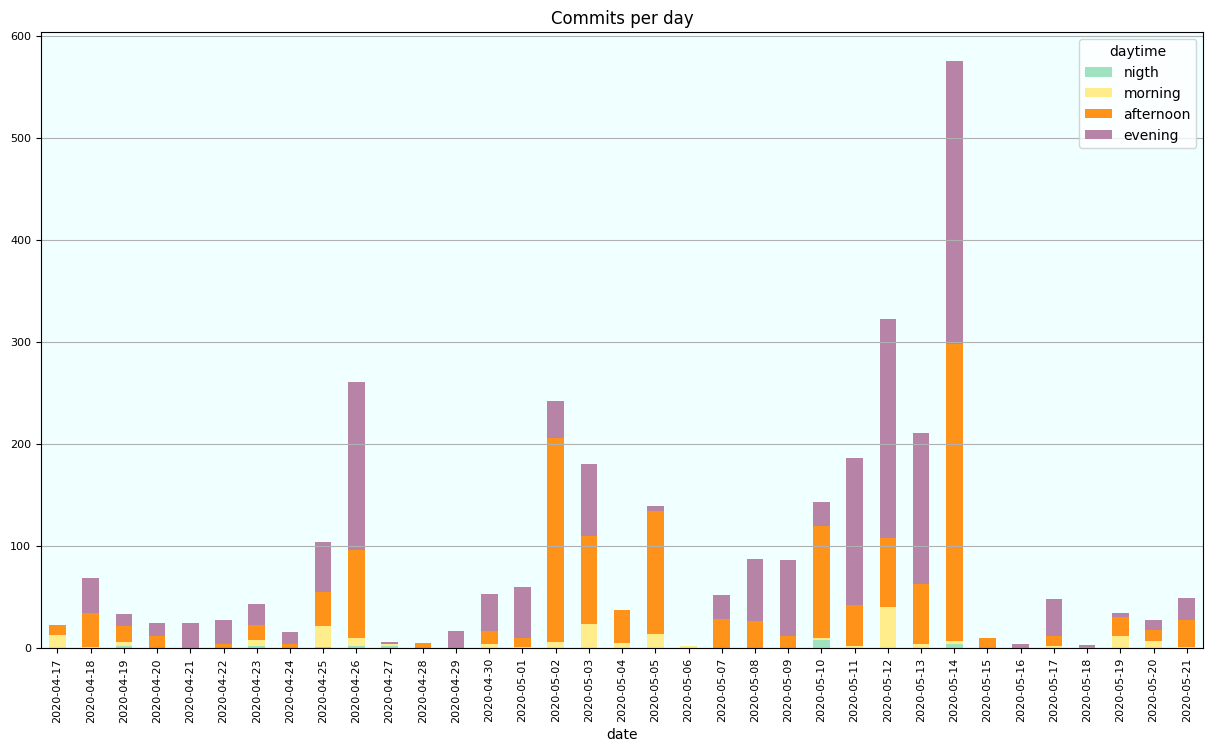

In [21]:
ax = commits_group.plot(kind='bar',
                   stacked=True,
                   figsize=(15, 8),
                   title='Commits per day',
                   fontsize=8,
                   rot=90,
                   color=['#9FE2BF', '#FFEC8B', '#FF9218', '#B784A7'])
ax.set_facecolor('#F0FFFF')
ax.grid('on', which='major', axis='y')

Посмотрим суммарное количество коммитов в определенное время суток

In [22]:
commits_group.sum()

daytime
nigth          21.0
morning       184.0
afternoon    1391.0
evening      1611.0
dtype: float64

Найдем день с наибольшим количеством коммитов такой, что количество коммитов вечером выше, чем днем

In [23]:
commits_group.loc[commits_group['evening'] > commits_group['afternoon']].sum(axis=1).idxmax()

datetime.date(2020, 5, 12)

Ответ: 12.05.2020

In [24]:
connect.close()